# BengaliAI Model Architecture

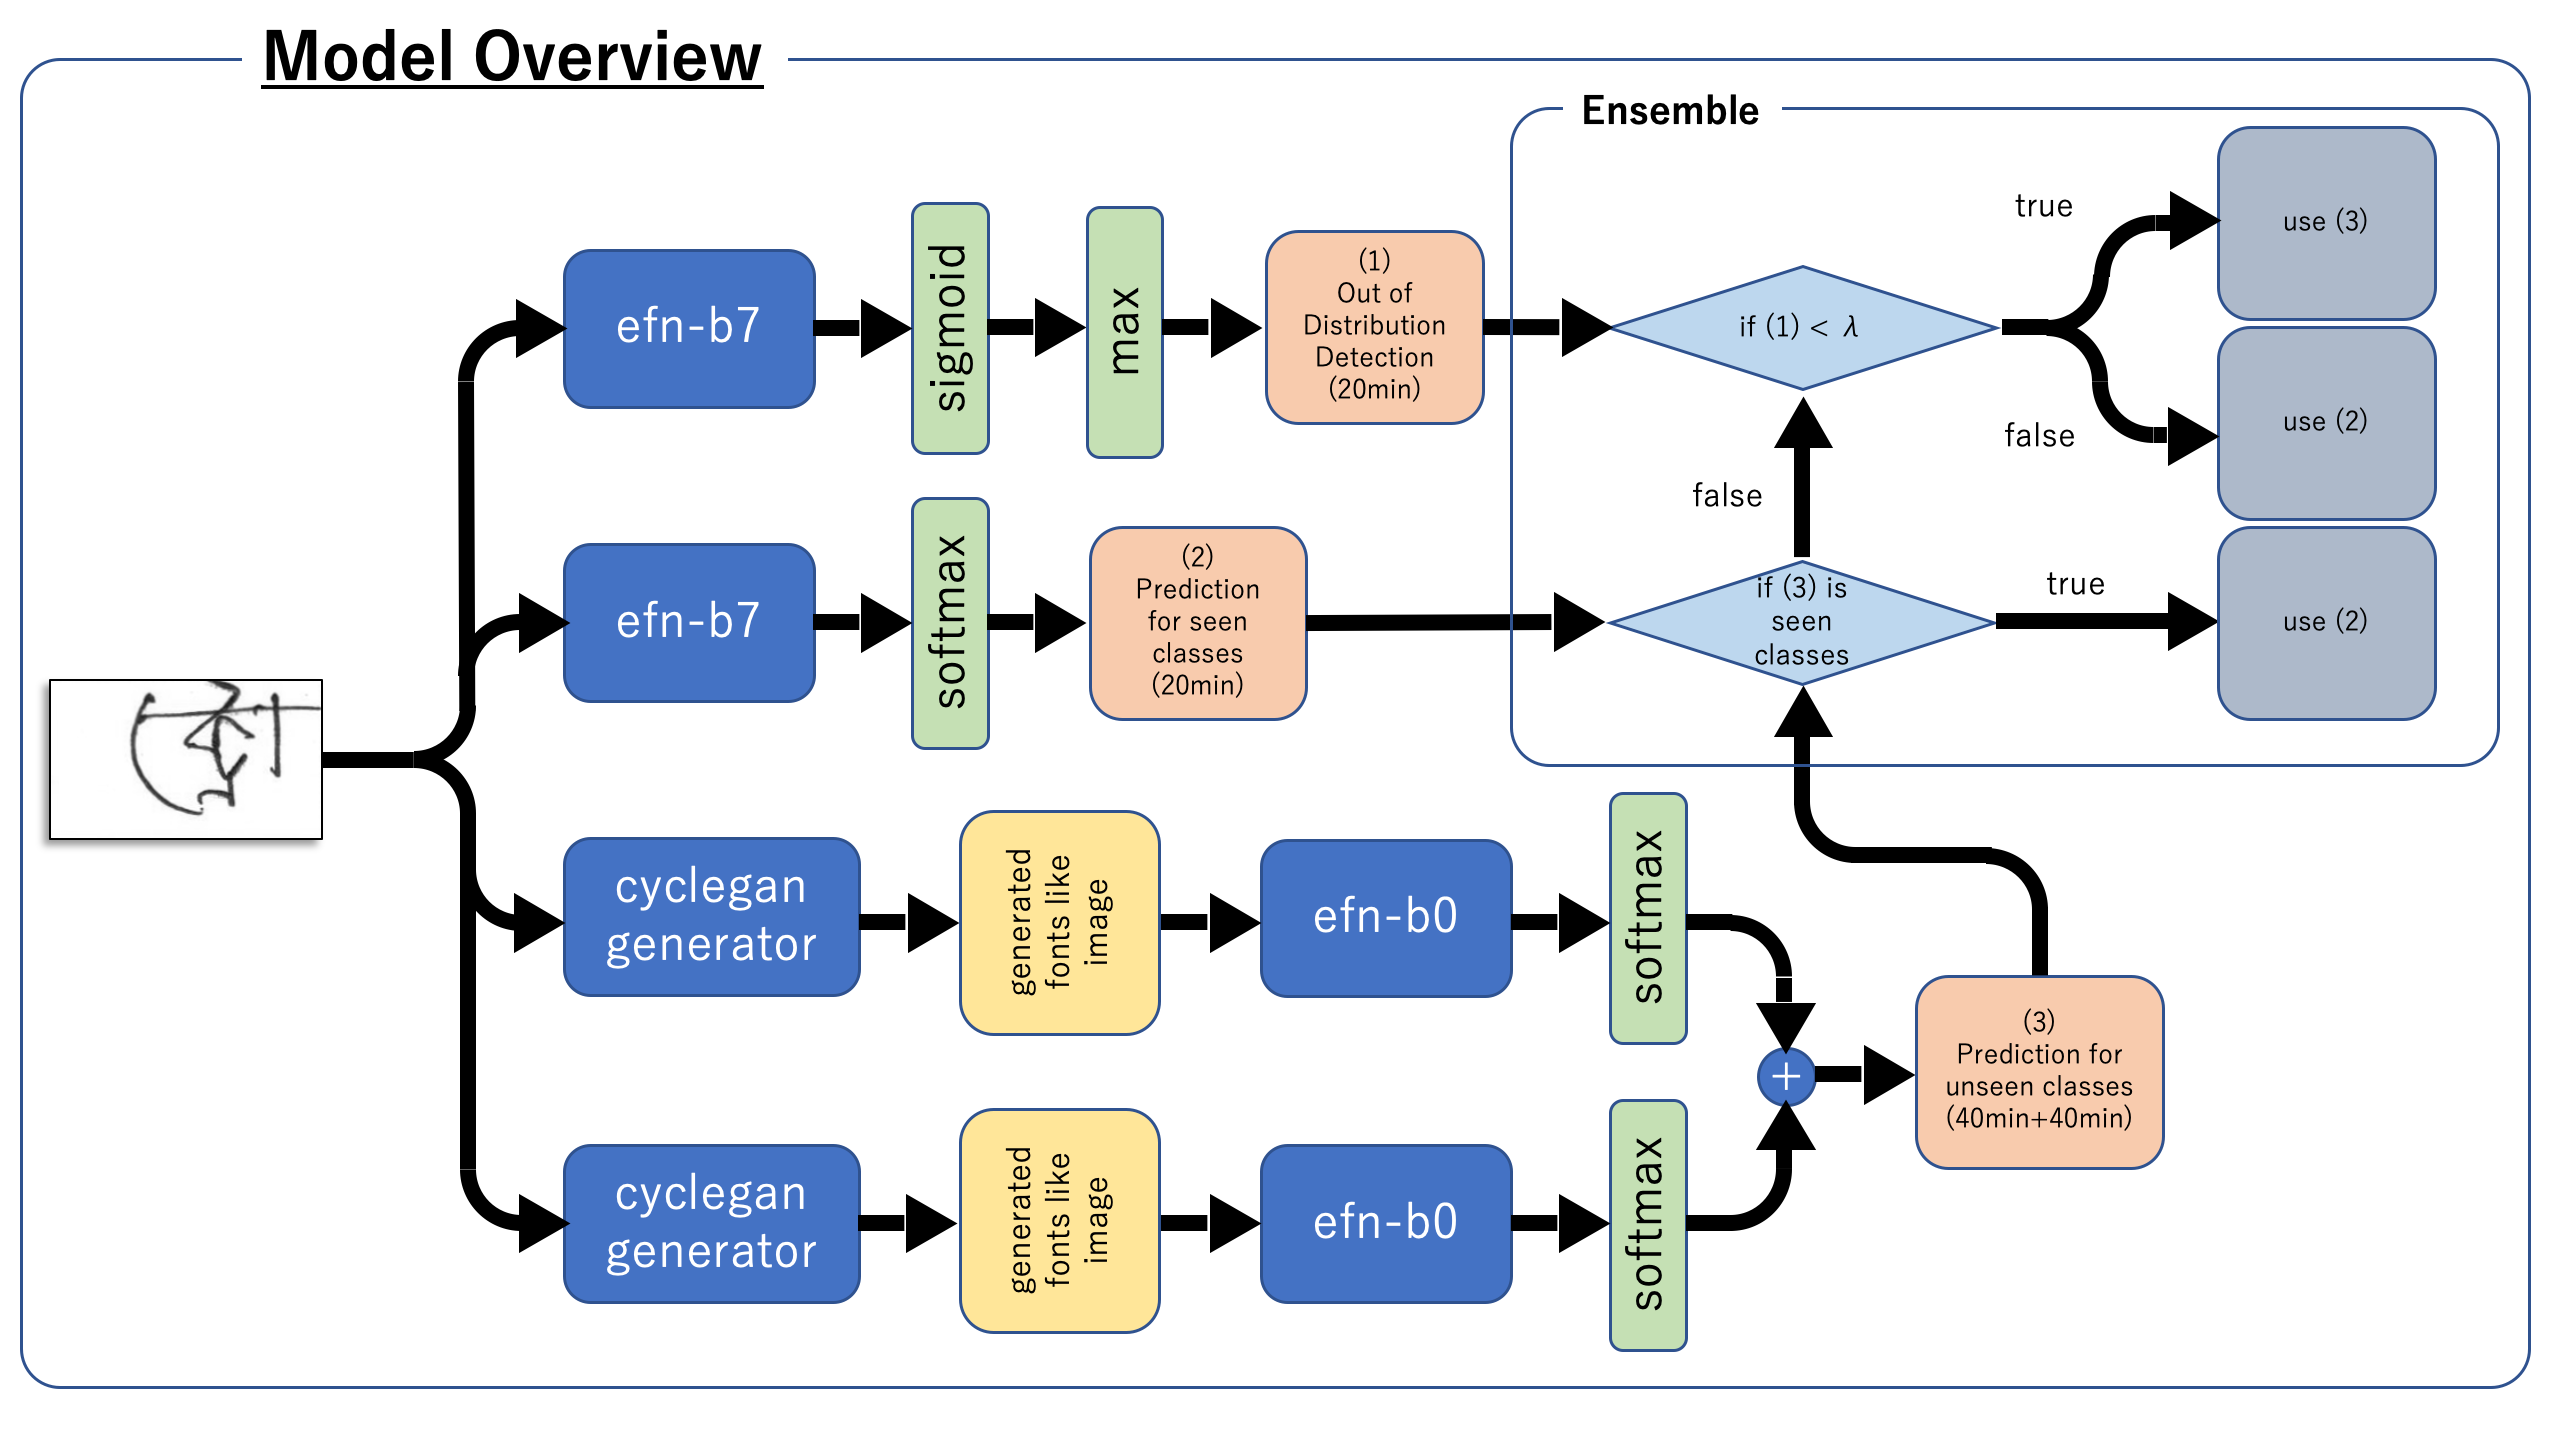

# Model Architecture Flow

- judge the image is seen or not.
- if seen, use the model train for seen to classify.
- if not, feed GAN the image and generilize a data-like image. After that, feed the output of GAN to the font classifier and classify.
- However, if the output of the pipeline when it is not "seen" is the "seen" class, the inference is performed again in the pipeline when it is "seen".

# Bengali CycleGAN Architecture

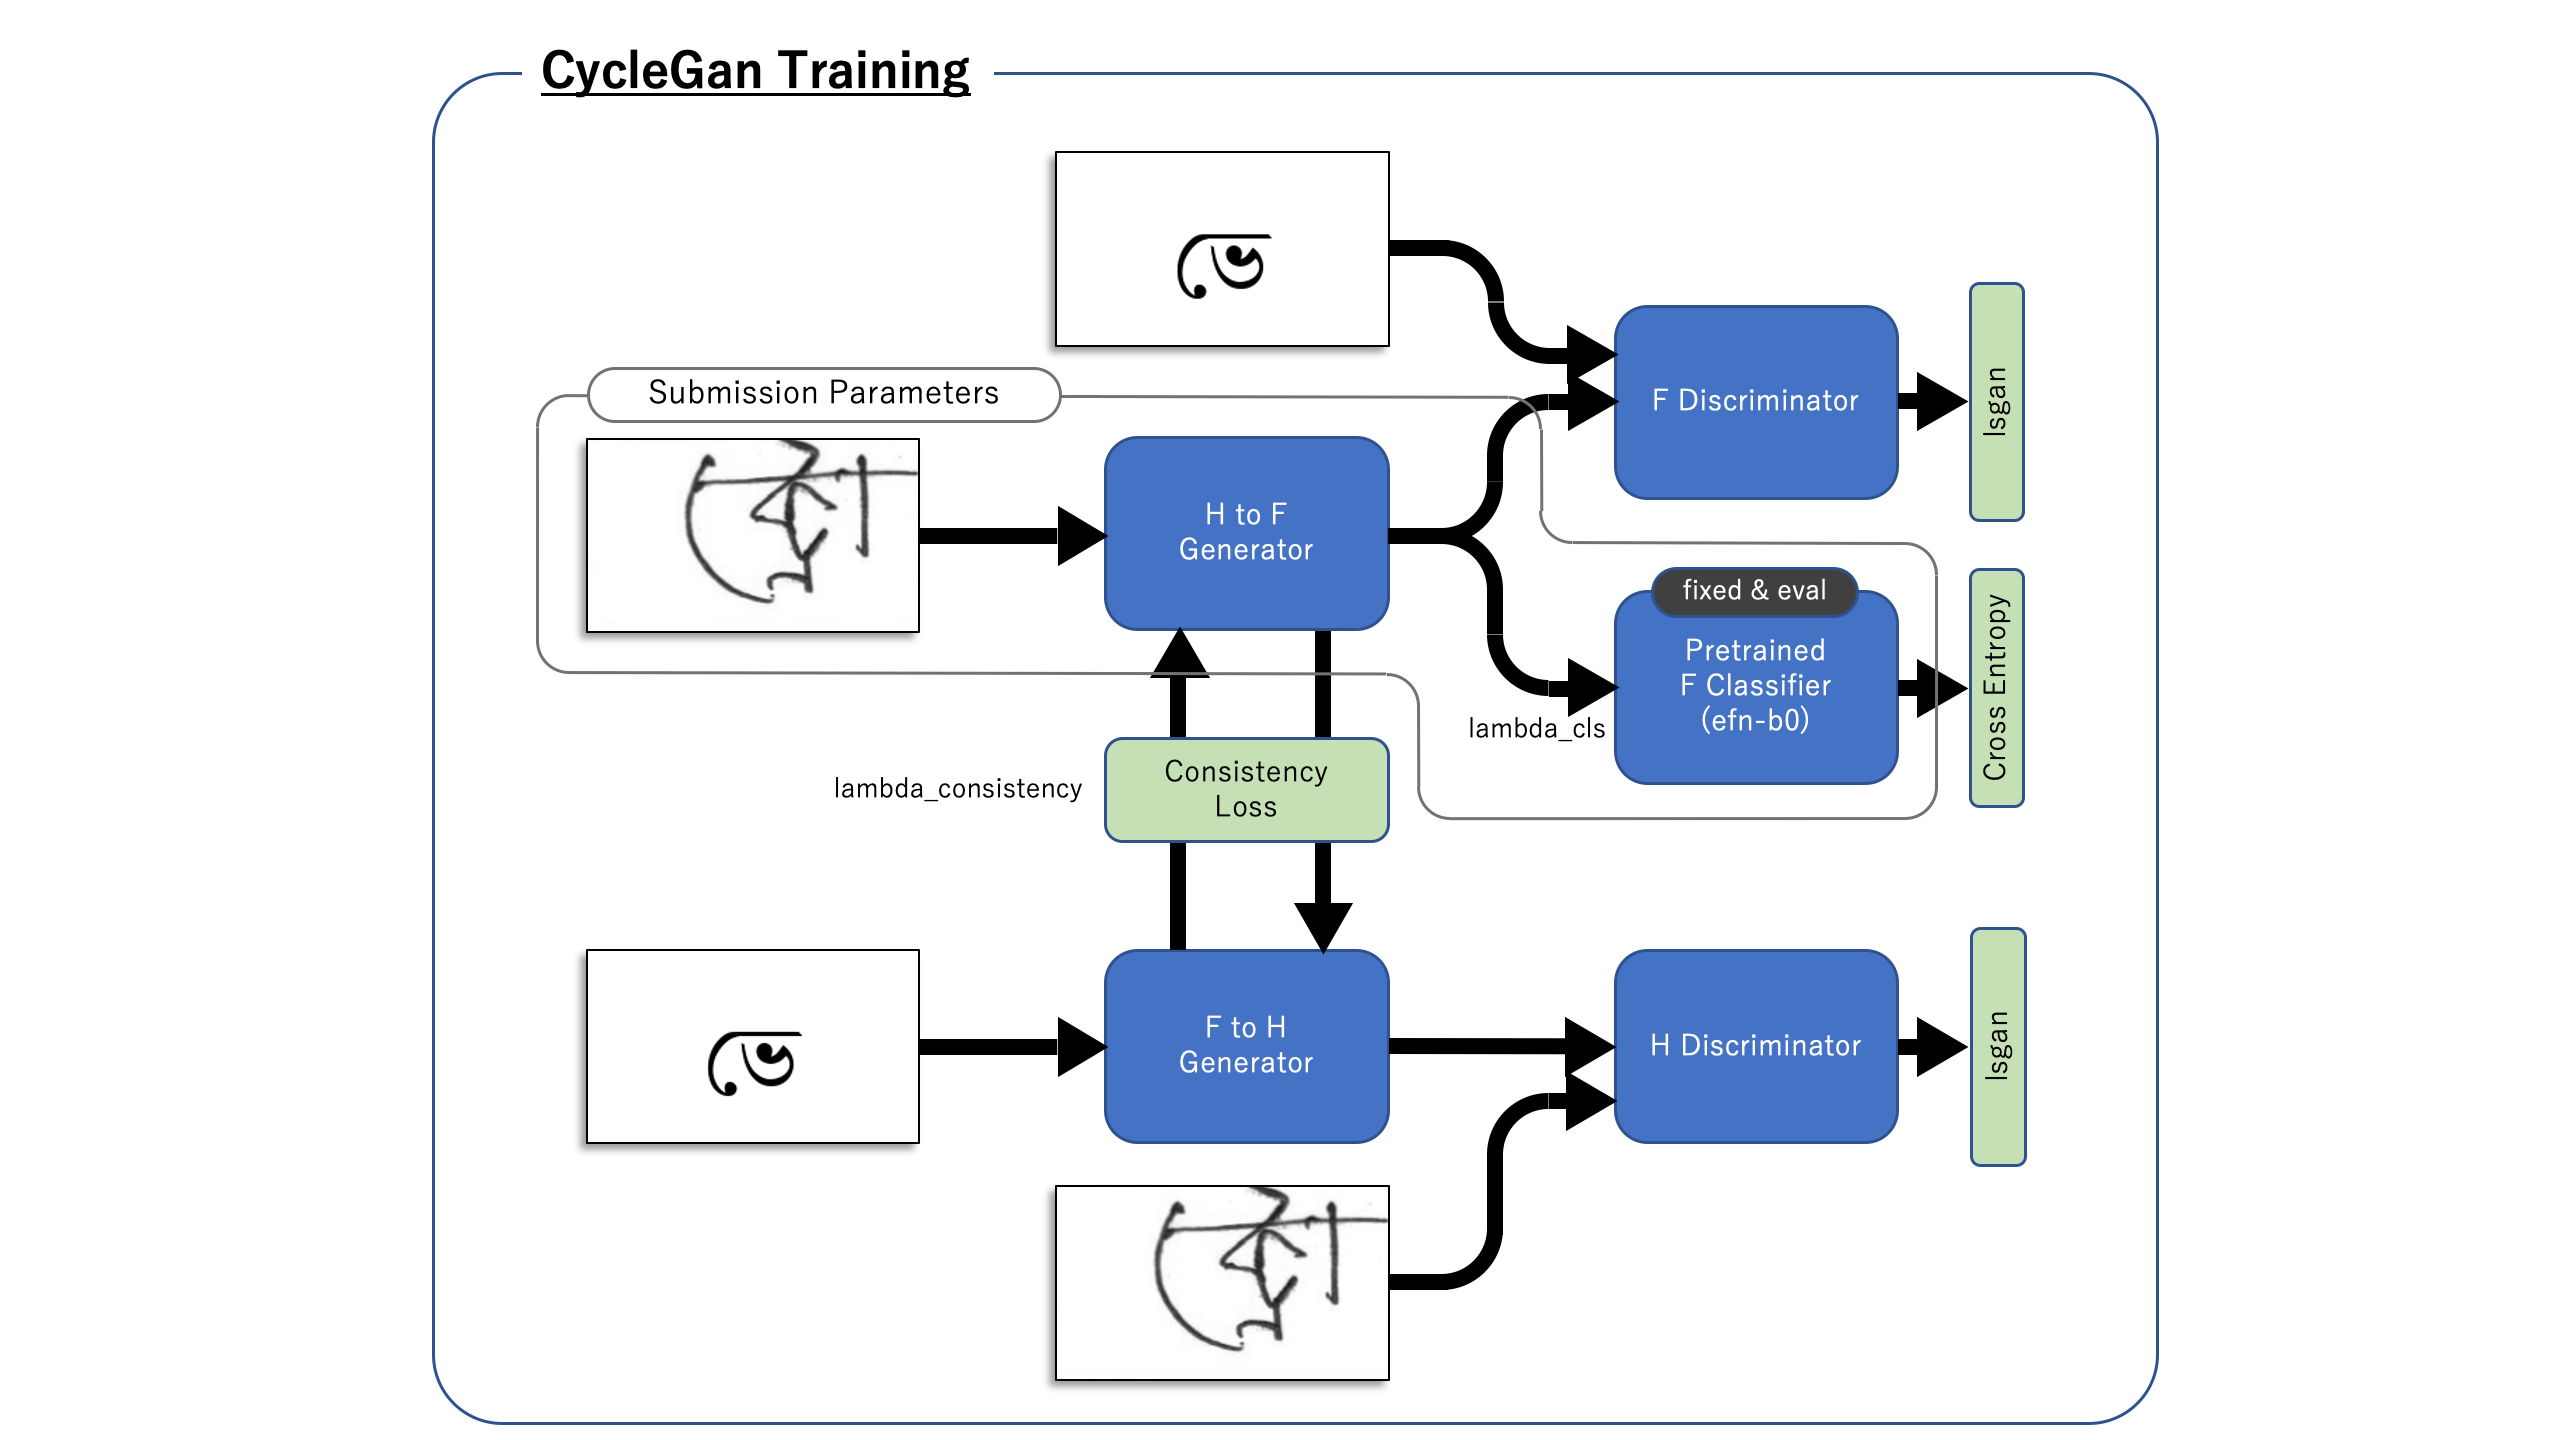

In [1]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=af6feffcb79ccdf68040fd7b874b59957f96cc1bce26b51271c0a3a8e5a260f9
  Stored in directory: /root/.cache/pip/wheels/1c/07/d1/ff77968842daae1dde944173a8e8a7be193646d37842f13b24
Successfully built efficientnet-pytorch


In [2]:
import os
import json
import functools

import torch
import torchvision
from torch import nn
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image
import albumentations as A
import sklearn.metrics

In [3]:
mode = 'test'

In [4]:
NUM_GRAPHEME_ROOT = 168
NUM_VOWEL_DIACRITIC = 11
NUM_CONSONANT_DIACRITIC = 8

class_map = pd.read_csv('../input/bengaliai-cv19/class_map.csv')
grapheme_root = class_map[class_map['component_type'] == 'grapheme_root']
vowel_diacritic = class_map[class_map['component_type'] == 'vowel_diacritic']
consonant_diacritic = class_map[class_map['component_type'] == 'consonant_diacritic']

grapheme_root_list = grapheme_root['component'].tolist()
vowel_diacritic_list = vowel_diacritic['component'].tolist()
consonant_diacritic_list = consonant_diacritic['component'].tolist()

In [5]:
device = torch.device("cuda")

# Font Classifier Model

In [6]:
class BengalModel(nn.Module):
    def __init__(self, backbone, hidden_size=2560, class_num=168*11*7):
        super(BengalModel, self).__init__()
        self.backbone = backbone
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(hidden_size, class_num)
        self.ln = nn.LayerNorm(hidden_size)

        
    def forward(self, inputs):
        bs = inputs.shape[0]
        feature = self.backbone.extract_features(inputs)
        feature_vector = self._avg_pooling(feature)
        feature_vector = feature_vector.view(bs, -1)
        feature_vector = self.ln(feature_vector)

        out = self.fc(feature_vector)
        return out

In [7]:
class Albumentations:
    def __init__(self, augmentations):
        self.augmentations = A.Compose(augmentations)
    
    def __call__(self, image):
        image = self.augmentations(image=image)['image']
        return image

In [8]:
class TestGraphemeDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        np_image = self.images[idx].copy()
        out_image = self.transform(np_image)
        
        return out_image, idx

In [9]:
def label_to_grapheme(grapheme_root, vowel_diacritic, consonant_diacritic):
    if consonant_diacritic == 0:
        if vowel_diacritic == 0:
            return grapheme_root_list[grapheme_root]
        else:
            return grapheme_root_list[grapheme_root] + vowel_diacritic_list[vowel_diacritic]
        
    elif consonant_diacritic == 1:
        if vowel_diacritic == 0:
            return grapheme_root_list[grapheme_root] + consonant_diacritic_list[consonant_diacritic]
        else:
            return grapheme_root_list[grapheme_root] + vowel_diacritic_list[vowel_diacritic] + \
                   consonant_diacritic_list[consonant_diacritic]
        
    elif consonant_diacritic == 2:
        if vowel_diacritic == 0:
            return consonant_diacritic_list[consonant_diacritic] + grapheme_root_list[grapheme_root]
        else:
            return consonant_diacritic_list[consonant_diacritic] + grapheme_root_list[grapheme_root] + \
                   vowel_diacritic_list[vowel_diacritic]
        
    elif consonant_diacritic == 3:
        if vowel_diacritic == 0:
            return consonant_diacritic_list[consonant_diacritic][:2] + grapheme_root_list[grapheme_root] + \
                   consonant_diacritic_list[consonant_diacritic][1:]
        else:
            return consonant_diacritic_list[consonant_diacritic][:2] + grapheme_root_list[grapheme_root] + \
                   consonant_diacritic_list[consonant_diacritic][1:] + vowel_diacritic_list[vowel_diacritic]
        
    elif consonant_diacritic == 4:
        if vowel_diacritic == 0:
            return grapheme_root_list[grapheme_root] + consonant_diacritic_list[consonant_diacritic]
        else:
            if grapheme_root == 123 and vowel_diacritic == 1:
                return grapheme_root_list[grapheme_root] + '\u200d' + consonant_diacritic_list[consonant_diacritic] + \
                       vowel_diacritic_list[vowel_diacritic]
            return grapheme_root_list[grapheme_root]  + consonant_diacritic_list[consonant_diacritic] + \
                   vowel_diacritic_list[vowel_diacritic]
        
    elif consonant_diacritic == 5:
        if vowel_diacritic == 0:
            return grapheme_root_list[grapheme_root] + consonant_diacritic_list[consonant_diacritic]
        else:
            return grapheme_root_list[grapheme_root] + consonant_diacritic_list[consonant_diacritic] + \
                   vowel_diacritic_list[vowel_diacritic]
        
    elif consonant_diacritic == 6:
        if vowel_diacritic == 0:
            return grapheme_root_list[grapheme_root] + consonant_diacritic_list[consonant_diacritic]
        else:
            return grapheme_root_list[grapheme_root] + consonant_diacritic_list[consonant_diacritic] + \
                   vowel_diacritic_list[vowel_diacritic]
        
    elif consonant_diacritic == 7:
        if vowel_diacritic == 0:
            return consonant_diacritic_list[2] + grapheme_root_list[grapheme_root] + consonant_diacritic_list[2][::-1]
        else:
            return consonant_diacritic_list[2] + grapheme_root_list[grapheme_root] + consonant_diacritic_list[2][::-1] + \
                   vowel_diacritic_list[vowel_diacritic]

# CycleGAN Generator

In [10]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

# Ensemble Models

In [11]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.model1 = models[0]
        self.model2 = models[1]
        
    def forward(self, images):
        return self.model1(images), self.model2(images)

In [12]:
def create_merc(classifier_load_path1, generator_load_path1,
                classifier_load_path2, generator_load_path2,
                images):
    MEAN = [0.5, 0.5, 0.5]
    STD = [0.5, 0.5, 0.5]
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    BATCH_SIZE = 32
    
    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    
    # generate font images from handwritten (H to F generator)
    generator_b1 = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, 
                                   norm_layer=norm_layer, 
                                   use_dropout=False, 
                                   n_blocks=9)
    
    # font-classifier to classify font_style graphemes
    backbone1 = EfficientNet.from_name('efficientnet-b0')
    classifier1 = BengalModel(backbone1, hidden_size=1280, 
                              class_num=NUM_GRAPHEME_ROOT*NUM_VOWEL_DIACRITIC*NUM_CONSONANT_DIACRITIC)
    
    # load pretrained classifier and generator 
    # and make a sequential model1 from them
    # classifier_1 trained on 1st ttf file
    classifier1.load_state_dict(torch.load(classifier_load_path1))
    generator_b1.load_state_dict(torch.load(generator_load_path1))
    model1 = nn.Sequential(generator_b1, classifier1)
    
    # generate font images from handwritten (H to F generator)
    generator_b2 = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, 
                                   norm_layer=norm_layer, 
                                   use_dropout=False, 
                                   n_blocks=9)
    
    # font-classifier to classify font_style graphemes
    backbone2 = EfficientNet.from_name('efficientnet-b0')
    classifier2 = BengalModel(backbone2, hidden_size=1280, 
                              class_num=NUM_GRAPHEME_ROOT*NUM_VOWEL_DIACRITIC*NUM_CONSONANT_DIACRITIC)
    
    # load pretrained classifier and generator 
    # and make a sequential model2 from them
    # classifier_2 trained on 2nd ttf file
    classifier2.load_state_dict(torch.load(classifier_load_path2))
    generator_b2.load_state_dict(torch.load(generator_load_path2))
    model2 = nn.Sequential(generator_b2, classifier2)
    
    # ensemble the two models and put into 
    # eval mode just for inference
    model = EnsembleModel([model1, model2])
    model.to(device)
    model.eval()
    
    # initialize grapheme label arrays
    grapheme_root_map = np.zeros((NUM_GRAPHEME_ROOT*NUM_VOWEL_DIACRITIC*NUM_CONSONANT_DIACRITIC), 
                                 dtype=np.int64)
    vowel_diacritic_map = np.zeros((NUM_GRAPHEME_ROOT*NUM_VOWEL_DIACRITIC*NUM_CONSONANT_DIACRITIC), 
                                   dtype=np.int64)
    consonant_diacritic_map = np.zeros((NUM_GRAPHEME_ROOT*NUM_VOWEL_DIACRITIC*NUM_CONSONANT_DIACRITIC), 
                                       dtype=np.int64)
    
    # fill all label arrays with respective combination(root, vowel, const)
    for grapheme_root in range(168):
        for vowel_diacritic in range(11):
            for consonant_diacritic in range(8):
                i = (((grapheme_root * NUM_VOWEL_DIACRITIC) + vowel_diacritic) * NUM_CONSONANT_DIACRITIC) + consonant_diacritic
                
                grapheme_root_map[i] = grapheme_root
                vowel_diacritic_map[i] = vowel_diacritic
                consonant_diacritic_map[i] = consonant_diacritic
                
    # pre-processing on images
    preprocess = [
        A.CenterCrop(height=137, width=IMG_WIDTH),
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True)
    ]
    
    # custom pytorch transform which will apply on each image
    transform = transforms.Compose([
        np.uint8,
        transforms.Lambda(lambda x: np.array([x, x, x]).transpose((1, 2, 0)) ),
        np.uint8,
        Albumentations(preprocess),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD),
        #     transforms.ToPILImage(),
    ])
    
    # make dataset and dataloader
    dataset = TestGraphemeDataset(images, transform)
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=4,
                                         pin_memory=True,
                                         drop_last=False)
    
    def out2pred(out):
        # out --> ensemble output --> ((32, 14784), (32, 14784))
        out1, out2 = out
        softmax = nn.Softmax(dim=1)
        
        out1 = softmax(out1)
        out2 = softmax(out2)
        
        out = out1 + out2
        
        # aggregating the predictions from 14784 graphemes into labels
        # e.g. for 1st root label, we will have total vowel*const=11*8=88
        # and first 88 predictions are for graphemes that have root=0 and if
        # we sum up those graphemes predictions that will contribute towards
        # grapheme_root=0 label prediction and similarly for vowels and consts
        box_out1 = out1.reshape((-1, NUM_GRAPHEME_ROOT, NUM_VOWEL_DIACRITIC, NUM_CONSONANT_DIACRITIC))
        grapheme_root_out = box_out1.sum(dim=(2, 3))
        vowel_diacritic_out = box_out1.sum(dim=(1, 3))
        consonant_diacritic_out = box_out1.sum(dim=(1, 2))
        
        box_out2 = out2.reshape((-1, NUM_GRAPHEME_ROOT, NUM_VOWEL_DIACRITIC, NUM_CONSONANT_DIACRITIC))
        grapheme_root_out += box_out2.sum(dim=(2, 3))
        vowel_diacritic_out += box_out2.sum(dim=(1, 3))
        consonant_diacritic_out += box_out2.sum(dim=(1, 2))
        
        grapheme_root_preds = grapheme_root_out.argmax(dim=1).cpu().numpy()
        vowel_diacritic_preds = vowel_diacritic_out.argmax(dim=1).cpu().numpy()
        consonant_diacritic_preds = consonant_diacritic_out.argmax(dim=1).cpu().numpy()
        
        preds = (((grapheme_root_preds * NUM_VOWEL_DIACRITIC) + vowel_diacritic_preds) * NUM_CONSONANT_DIACRITIC) + \
                consonant_diacritic_preds
        
        ret = []
        for p, g, v, co in zip(preds, grapheme_root_preds, vowel_diacritic_preds, consonant_diacritic_preds):
            x = {
                'pred': p,
                'grapheme_root': g,
                'vowel_diacritic': v,
                'consonant_diacritic': co,
                'grapheme': label_to_grapheme(g, v, co),
            }
            
            ret.append(x)
            
        return ret
    
    return model, loader, out2pred

In [13]:
def evaluator(model, loader, out2pred):
    ret = []
    model.eval()
    
    for (images, idx) in tqdm(loader):
        images = images.to(device)
        with torch.no_grad():
            out = model(images)
            ret += out2pred(out)
            
    return ret

In [14]:
def load_images(path):
    images_df = pd.read_parquet(path)
    images = images_df.iloc[:, 1:].values.reshape(-1, 137, 236)
    return images

In [15]:
merc_result = []

- Here, both classifiers and both generators are same for simplicity but actually they will be different classifiers trained on separate .ttf files and hence both generators will also be different ... one will include first classifier and second will include the other classifier.

In [16]:
classifier1_path = '../input/cyclegan-classifier-results/best.pth'
generator1_path = '../input/cyclegan-training-results/generator.pth'
classifier2_path = '../input/cyclegan-classifier-results/best.pth'
generator2_path = '../input/cyclegan-training-results/generator.pth'

In [17]:
images = load_images('../input/bengaliai-cv19/{}_image_data_0.parquet'.format(mode))
model, loader, out2pred = create_merc(classifier1_path, generator1_path,
                                      classifier2_path, generator2_path,
                                      images)

merc_result += evaluator(model, loader, out2pred)

In [18]:
images = load_images('../input/bengaliai-cv19/{}_image_data_1.parquet'.format(mode))
model, loader, out2pred = create_merc(classifier1_path, generator1_path,
                                      classifier2_path, generator2_path,
                                      images)

merc_result += evaluator(model, loader, out2pred)

In [19]:
images = load_images('../input/bengaliai-cv19/{}_image_data_2.parquet'.format(mode))
model, loader, out2pred = create_merc(classifier1_path, generator1_path,
                                      classifier2_path, generator2_path,
                                      images)

merc_result += evaluator(model, loader, out2pred)

In [20]:
images = load_images('../input/bengaliai-cv19/{}_image_data_3.parquet'.format(mode))
model, loader, out2pred = create_merc(classifier1_path, generator1_path,
                                      classifier2_path, generator2_path,
                                      images)

merc_result += evaluator(model, loader, out2pred)

In [21]:
merc_result_df = pd.DataFrame(merc_result)

In [22]:
merc_result_df.head()

,pred,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,184,2,1,0,অা
1,10400,118,2,0,ম্বি
2,10208,116,0,0,ম্ন
3,10120,115,0,0,ম
4,5229,59,4,5,ণ্রু


In [23]:
def create_inference(merc_result_df):
    ret = []
    
    for merc_row in merc_result_df.itertuples():
        inference = {}
        inference['grapheme_root'] = merc_row.grapheme_root
        inference['vowel_diacritic'] = merc_row.vowel_diacritic
        inference['consonant_diacritic'] = merc_row.consonant_diacritic
        inference['grapheme'] = merc_row.grapheme
        
        ret.append(inference)
        
    return pd.DataFrame(ret)

In [24]:
inference = create_inference(merc_result_df)

In [25]:
inference.head()

,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,2,1,0,অা
1,118,2,0,ম্বি
2,116,0,0,ম্ন
3,115,0,0,ম
4,59,4,5,ণ্রু


In [26]:
def submit(inference):
    row_id_list = []
    target_list = []
    
    for i, row in inference.iterrows():
        row_id_list.append('Test_{}_grapheme_root'.format(i))
        target_list.append(row.grapheme_root)
        
        row_id_list.append('Test_{}_grapheme_root'.format(i))
        target_list.append(row.vowel_diacritic)
        
        row_id_list.append('Test_{}_grapheme_root'.format(i))
        if row.consonant_diacritic == 7:
            target_list.append(2)
        else:
            target_list.append(row.consonant_diacritic)
            
    raw_submission = {
        'row_id': row_id_list,
        'target': target_list
    }
    
    submission = pd.DataFrame(raw_submission)
    display(submission)
    submission.to_csv('submission.csv', index=False)

In [27]:
submit(inference)

,row_id,target
0,Test_0_grapheme_root,2
1,Test_0_grapheme_root,1
2,Test_0_grapheme_root,0
3,Test_1_grapheme_root,118
4,Test_1_grapheme_root,2
5,Test_1_grapheme_root,0
6,Test_2_grapheme_root,116
7,Test_2_grapheme_root,0
8,Test_2_grapheme_root,0
9,Test_3_grapheme_root,115
